# MAE271B Project, Banseok Lee
- Missile State Estimation
- Mechanical Engineering
- UID : 605351891 

### Introduction

This project is a simulation for estimating a state of missile intercept<br>
Write a program by using Jupyter notebook <br>
- Language: Python<br>
- Library use: NumPy, Pyplot, os, time<br>

##### The simulation algorithm is designed by order as follows<br>
1) Check the variables and constants for the simulation<br>
2) Design state-space dynamic system equation for a state = (y, v, a)<br>
3) Estimate state by continuous Kalman filter algorithm.<br>
4) Compute Kalman gain equation<br>
5) Derive error covariance propagation matrix(Riccati equation)<br>


##### After designing the algorithm the simulation is processed as follows<br>
1) Initialize empty state, history dictionaries<br>
2) Initialize constant variables and Gaussian random variables<br>
3) Compute initialize state(0) of all equation<br>
4) For the iteration, 1000 times repeat 5~10<br>
5) For discrete-time step 0.001sec, process 6~10 through the 10sec<br>
6) From the Riccati equation, Update error variance<br>
7) Compute Kalman gain<br>
8) Update measurement, process noise<br>
9) Update actual, estimate state<br>
10) log the residuals and errors<br>
11) Change the Gaussian process noise to the random telegraph signal and repeat 4~10<br>

### Simulation

In [1]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import time

Declare a class for Missile State Estimation simulation.
The class, MissileStateEstimation(MSE) contains useful variables and functions as follows
- variables : Vc, tf, R1, R2, lamda ...
- functions : Initialize, Process ...


In [37]:
class MissileStateEstimation(object):
    # For MAE271B Project
    # 605351891 BANSEOK LEE
#-----------------------------------------------------------------------------------#    
    # Take input variables
    # Declare variables as global variables
    
    def __init__(self, Vc = 300, tf = 10, R1 = 15*(10**(-6)),
               R2 = 1.67*(10**(-3)), tau = 2, W = 100**2, dt = 0.001,
               Ea = 0, Eaa = 100**2, Ey = 0, Eyy = 0,
                 Ev = 0, Evv = 200**2, itr=1000, RTS_at0 = 100, lamda=0.25):
        T = np.arange(0, 10, dt) 
        self.En = 0
        self.Enn = (R1+(R2/(tf**2)))/dt
        self.T = T
        self.Vc = Vc
        self.tf, self.dt = tf, dt
        self.R1, self.R2 = R1 , R2
        self.tau = tau
        self.Ea, self.Eaa, self.Ey, self.Eyy, self.Ev, self.Evv = Ea, Eaa, Ey, Eyy, Ev, Evv
        self.W, self.itr = W, itr
        self.lamda = lamda
        self.RTS_at0 = RTS_at0
#-----------------------------------------------------------------------------------#       
    # Initialize parameters (store in Log, Icache dictionaries)
    # input : global variables, simulation sequence j
    # output : Icache, Log dictionaries
    # Icache : storing all variables
    # Log : storing all histories
    
    def Initialize(self, j):
        Icache = {}
        Log = {}
        
        # Initial state matrices
        F = np.array([[0, 1, 0],[0, 0, -1],[0, 0, -(1//self.tau)]])
        G = np.array([[0], [0], [1]])
        H0 = np.array([[1/(self.Vc*self.tf), 0, 0]])
        V0 = self.R1 + (self.R2//(self.tf^2))
        y0 = self.Ey + np.random.randn()*np.sqrt(self.Eyy)
        v0 = self.Ev + np.random.randn()*np.sqrt(self.Evv)
        at0 = self.Ea + np.random.randn()*np.sqrt(self.Eaa)              
        P0 = np.array([[self.Eyy, 0, 0],[0, self.Evv, 0],[0, 0, self.Eaa]])
        RTS_at0 = self.RTS_at0
        
        # Initial random gaussian noise
        n = self.En + np.random.randn()*np.sqrt(self.Enn) 
        Wat = self.Ea + np.random.randn()*np.sqrt(self.Eaa//self.dt)
        
        # Initial random telegraph signal
        # -100 (p=0.5) or 100 (p=0.5)
        temp = np.random.rand()
        if temp > 0.5:
            RTS_at0 = RTS_at0
        else:
            RTS_at0 = - RTS_at0
        Icache['P0'] = P0
        Icache['F'], Icache['G'] = F, G   
        Icache['H0'], Icache['V0'], Icache['y0'] = H0, V0, y0
        Icache['v0'], Icache['at0'], Icache['n'] = v0, at0, n
        Icache['Wat'] = Wat
        
        # generating random telegraph signal
        RTS_atlog = np.zeros((len(self.T)))
        RTS_atlog[0] = RTS_at0
        for i in range(len(self.T)-1):
            temp = np.random.rand()
            if temp < 1 - np.exp(-self.lamda*self.dt):
                RTS_atlog[i+1] = - RTS_atlog[i]
            else:
                RTS_atlog[i+1] = RTS_atlog[i]
        
        Plog = np.zeros((3, 3, len(self.T)))
        RTS_Plog = np.zeros((3, 3, len(self.T)))
        Klog = np.zeros((3, 1, len(self.T)))
        RTS_Klog = np.zeros((3, 1, len(self.T)))
        Zlog = np.zeros(len(self.T))
        RTS_Zlog = np.zeros(len(self.T))
        xhatlog = np.zeros((3, 1, len(self.T)))
        dxhatlog = np.zeros((3, 1, len(self.T)))
        RTS_xhatlog = np.zeros((3, 1, len(self.T)))
        RTS_dxhatlog = np.zeros((3, 1, len(self.T)))   
        xlog = np.zeros((3, 1, len(self.T)))
        dxlog = np.zeros((3, 1, len(self.T)))
        RTS_xlog = np.zeros((3, 1, len(self.T)))
        RTS_dxlog = np.zeros((3, 1, len(self.T)))
        errlog = np.zeros((3, 1, len(self.T), self.itr))
        residual = np.zeros((1, len(self.T), self.itr))
        RTS_errlog = np.zeros((3, 1, len(self.T), self.itr))
        RTS_residual = np.zeros((1, len(self.T), self.itr))

        Plog[:, :, 0] = P0
        Klog[:, :, 0] = P0 @ H0.T * (1//V0)
        RTS_Plog[:, :, 0] = P0
        RTS_Klog[:, :, 0] = P0 @ H0.T * (1//V0)
        
        xlog[:, :, 0] = np.array([[y0], [v0], [at0]])
        dxlog[:, :, 0] = F @ xlog[:, :, 0] + G * Wat
        Zlog[0] = H0 @ xlog[:, :, 0] + n 
        dxhatlog[:, :, 0] = F @ xhatlog[:, :, 0] + Klog[:, :, 0] @ (Zlog[0] - H0 @ xhatlog[:, :, 0])
        
        RTS_xlog[:, :, 0] = np.array([[y0], [v0], [RTS_at0]])
        RTS_dxlog[:, :, 0] = F @ RTS_xlog[:, :, 0] + G * RTS_at0
        RTS_Zlog[0] = H0 @ RTS_xlog[:, :, 0] + n 
        RTS_dxhatlog[:, :, 0] = F @ RTS_xhatlog[:, :, 0] + RTS_Klog[:, :, 0] @ (RTS_Zlog[0] - H0 @ RTS_xhatlog[:, :, 0])
    
        Log['Plog'], Log['Klog'], Log['Zlog'] = Plog, Klog, Zlog
        Log['xhatlog'], Log['dxhatlog'], Log['xlog'] = xhatlog, dxhatlog, xlog
        Log['dxlog'], Log['errlog'], Log['residual'] = dxlog, errlog, residual
        Log['RTS_atlog'], Log['RTS_Plog'],Log['RTS_Klog'], Log['RTS_Zlog'] = RTS_atlog, RTS_Plog,RTS_Klog, RTS_Zlog
        Log['RTS_xhatlog'], Log['RTS_dxhatlog'], Log['RTS_xlog'] = RTS_xhatlog, RTS_dxhatlog, RTS_xlog
        Log['RTS_dxlog'], Log['RTS_errlog'], Log['RTS_residual'] = RTS_dxlog, RTS_errlog, RTS_residual
        return Icache, Log
    
#-----------------------------------------------------------------------------------#      
    # Update process for ith time & jth simulation
    # Input : self variables, Icache, Log, time i, iteration j.
    # Output : updated Log, Icache,and time i+1 , iteration j states
        
    def Process(self, Icache, Log, i, j):
        
        Plog, Klog, Zlog = Log['Plog'], Log['Klog'], Log['Zlog']
        xhatlog, dxhatlog, xlog  = Log['xhatlog'], Log['dxhatlog'], Log['xlog'] 
        dxlog, errlog, residual = Log['dxlog'], Log['errlog'], Log['residual']
        RTS_atlog, RTS_Plog,RTS_Klog, RTS_Zlog = Log['RTS_atlog'], Log['RTS_Plog'],Log['RTS_Klog'], Log['RTS_Zlog'] 
        RTS_xhatlog, RTS_dxhatlog, RTS_xlog = Log['RTS_xhatlog'], Log['RTS_dxhatlog'], Log['RTS_xlog'] 
        RTS_dxlog, RTS_errlog, RTS_residual = Log['RTS_dxlog'], Log['RTS_errlog'], Log['RTS_residual'] 
        
        P0 = Icache['P0']
        F, G = Icache['F'], Icache['G']
        H0, V0, y0 = Icache['H0'], Icache['V0'], Icache['y0']
        v0, at0, n = Icache['v0'], Icache['at0'], Icache['n']
        Wat = Icache['Wat']
        
        H = np.array([[1/(self.Vc*(self.tf-self.T[i])), 0, 0]])
        V = self.R1 + (self.R2/((self.tf-self.T[i])**2))

        # Update Error Variance, Kalman gain
        Pdot = F @ Plog[:,:,i] + Plog[:,:,i] @ F.T - \
                Plog[:,:,i] @ (H.T * V**(-1)) @ H @ Plog[:, :, i] + \
                G @ G.T * self.Eaa 
        RTS_Pdot = F @ RTS_Plog[:,:,i] + RTS_Plog[:,:,i] @ F.T - \
                RTS_Plog[:,:,i] @ (H.T * V**(-1)) @ H @ RTS_Plog[:, :, i] + \
                G @ G.T * self.Eaa 
                
        Plog[:, :, i+1] = Plog[:, :, i] + Pdot * self.dt
        RTS_Plog[:, :, i+1] = RTS_Plog[:, :, i] + RTS_Pdot * self.dt
        Klog[:, :, i+1] = Plog[:, :, i] @ H.T * (V**(-1))
        RTS_Klog[:, :, i+1] = RTS_Plog[:, :, i] @ H.T * (V**(-1))
        
        # Update measurement, process noise,and Random Telegraph Signal
        n = self.En + np.random.randn() * np.sqrt(V/self.dt)
        Wat = self.Ea + np.random.randn() * np.sqrt(self.Eaa/self.dt)
        nforRTS = self.En + np.random.randn() * np.sqrt(V/self.dt)
        RTSWat = RTS_atlog[i]
        
        # Update actual, estimate states
        dxlog[:, :, i+1] = F @ xlog[:, :, i] + G * Wat
        xlog[:, :, i+1] = xlog[:, :, i] + dxlog[:, :, i+1] * self.dt
        Zlog[i+1] = H @ xlog[:, :, i+1] + n
        dxhatlog[:, :, i+1] = F @ xhatlog[:,:,i] + Klog[:,:,i+1] @ (Zlog[i+1]-H @ xhatlog[:,:,i])
        xhatlog[:, :, i+1] = xhatlog[:, :, i] + dxhatlog[:, :, i+1] * self.dt
        
        RTS_dxlog[:, :, i+1] = F @ RTS_xlog[:, :, i] + G * RTSWat
        RTS_xlog[:, :, i+1] = RTS_xlog[:, :, i] + RTS_dxlog[:, :, i+1] * self.dt
        RTS_Zlog[i+1] = H @ RTS_xlog[:, :, i+1] + nforRTS
        RTS_dxhatlog[:, :, i+1] = F @ RTS_xhatlog[:,:,i] + RTS_Klog[:,:,i+1] @ (RTS_Zlog[i+1]-H @ RTS_xhatlog[:,:,i])
        RTS_xhatlog[:, :, i+1] = RTS_xhatlog[:, :, i] + RTS_dxhatlog[:, :, i+1] * self.dt
        
        # Residual, Error
        residual[:, i+1, j] = Zlog[i+1] - H @ xhatlog[:, :, i+1]
        errlog[:, :, i+1, j] = xhatlog[:, :, i+1] - xlog[:, :, i+1]

        RTS_residual[:, i+1, j] = RTS_Zlog[i+1] - H @ RTS_xhatlog[:, :, i+1]
        RTS_errlog[:, :, i+1, j] = RTS_xhatlog[:, :, i+1] - RTS_xlog[:, :, i+1]
        
        Log['Plog'], Log['Klog'], Log['Zlog'] = Plog, Klog, Zlog
        Log['xhatlog'], Log['dxhatlog'], Log['xlog'] = xhatlog, dxhatlog, xlog
        Log['dxlog'], Log['errlog'], Log['residual'] = dxlog, errlog, residual
        Log['RTS_atlog'], Log['RTS_Plog'],Log['RTS_Klog'], Log['RTS_Zlog'] = RTS_atlog, RTS_Plog,RTS_Klog, RTS_Zlog
        Log['RTS_xhatlog'], Log['RTS_dxhatlog'], Log['RTS_xlog'] = RTS_xhatlog, RTS_dxhatlog, RTS_xlog
        Log['RTS_dxlog'], Log['RTS_errlog'], Log['RTS_residual'] = RTS_dxlog, RTS_errlog, RTS_residual
        
        Icache['P0'] = P0
        Icache['F'], Icache['G'] = F, G   
        Icache['H0'], Icache['V0'], Icache['y0'] = H0, V0, y0
        Icache['v0'], Icache['at0'], Icache['n'] = v0, at0, n
        Icache['Wat'] = Wat
        return Icache, Log  
#-----------------------------------------------------------------------------------#               
    # Draw plots for the problem 1
    # Compute the error variance of the error in the state and the associate Kalman filter gains.
    def plot_for_problem_1(self, Log):
        Plog, kLog = Log['Plog'], Log['Klog']
        
        plt.figure(1)
        plt.title('Filter Gain History')
        plt.plot(T, np.squeeze(Klog[0, :, :].T),  'g')
        plt.plot(T, np.squeeze(Klog[1, :, :].T), 'b--')
        plt.plot(T, np.squeeze(Klog[2, :, :].T), 'm:')
        plt.legend(['$K_1$', '$K_2$', '$K_3$'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Kalman Filter Gains')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(2)
        plt.title('Evolution of the Estimation Error RMS')
        plt.plot(T, np.squeeze(Plog[0, 0, :]**0.5), 'g')
        plt.plot(T, np.squeeze(Plog[1, 1, :]**0.5), 'k--')
        plt.plot(T, np.squeeze(Plog[2, 2, :]**0.5), 'r:')
        plt.legend(['RMS error in porition ($ft$)' 
                    , 'RMS error in velocity ($ft sec^{-1}$)'
                    , 'RMS error in acceleration ($ft sec^{-2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Standard deviation of the state error')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()
        return None
#-----------------------------------------------------------------------------------#                 
    # Draw plots for the problem 2
    # Develop a simulation for the dynamics and the measurement.  
    def plot_for_problem_2(self, Log):
        Plog, Klog, Zlog = Log['Plog'], Log['Klog'], Log['Zlog']
        xhatlog, dxhatlog, xlog  = Log['xhatlog'], Log['dxhatlog'], Log['xlog'] 
        dxlog, errlog, residual = Log['dxlog'], Log['errlog'], Log['residual']
        
        plt.figure(3)
        plt.title('Dynamic simulation for position')
        plt.plot(T, np.squeeze(xhatlog[0, 0, :]), '#2ca02c')
        plt.plot(T, np.squeeze(xlog[0, 0, :]), 'g--')
        plt.legend(['Estimate position ($ft$)' 
                    , 'Actual position ($ft$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Position ($ft$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(4)
        plt.title('Dynamic simulation for velocity')
        plt.plot(T, np.squeeze(xhatlog[1, 0, :]),'#7f7f7f')
        plt.plot(T, np.squeeze(xlog[1, 0, :]), 'k--')
        plt.legend(['Estimate velocity ($ft sec^{-1}$)' 
                    , 'Actual velocity ($ft sec^{-1}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Velocity ($ft sec^{-1}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(5)
        plt.title('Dynamic simulation for acceleration')
        plt.plot(T, np.squeeze(xhatlog[2, 0, :]),'#d62728')
        plt.plot(T, np.squeeze(xlog[2, 0, :]), 'r--')
        plt.legend(['Estimate acceleration ($ft sec^{-2}$)' 
                    , 'Actual acceleration ($ft sec^{-2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Acceleration ($ft sec^{-2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()    
        
        plt.figure(6)
        plt.title('Measurement')
        plt.plot(T[5000:6000], np.squeeze(Zlog[5000:6000]),'#d62728',lw=1)
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Measurement (-)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()    
        return None
#-----------------------------------------------------------------------------------#     
    # Calculate Average Error variance for the problem 3
    # Show by a Monte Carlo simulation that the actual error variance computed in the simulation
    # matches the a priori error variance used in the Kalman filter gains.     
    def AverageP(self, errstack, errtotal, T, itr):
        Pavgg = np.zeros((3, 3, len(T))) 
        erravg = errtotal/itr
        for j in range(itr):
            for i in range(len(T)):
                Pavgg[:,:,i] += (errstack[:,:,i,j] - erravg[:,:,i]) @ (errstack[:,:,i,j] - erravg[:,:,i]).T
        Pavgg /= itr-1
        return Pavgg
#-----------------------------------------------------------------------------------#  
    # Draw plots for the problem 3
    # Show by a Monte Carlo simulation that the actual error variance computed in the simulation
    # matches the a priori error variance used in the Kalman filter gains.              
    def plot_for_problem_3(self, Log, Pavg, itr):
        Plog = Log['Plog']

        plt.figure(6)
        plt.title('Monte Carlo simulation(%r times) for Position' %itr )  
        plt.plot(T, Pavg[0, 0, :]**0.5, '#2ca02c')
        plt.plot(T, Plog[0, 0, :]**0.5,  'g--')
        plt.legend(['A priori error variance for position ($ft^{2}$)' 
                    , 'Actual error variance for position ($ft^{2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Position ($ft^{2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(7)
        plt.title('Monte Carlo simulation(%r times) for Velocity' %itr )
        plt.plot(T, Pavg[1, 1, :]**0.5, '#7f7f7f')
        plt.plot(T, Plog[1, 1, :]**0.5, 'k--')
        plt.legend(['A priori error variance for velocity ($(ft sec^{-1})^{2}$)' 
                    , 'Actual error variance for velocity ($(ft sec^{-1})^{2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Velocity ($(ft sec^{-1})^{2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(8)
        plt.title('Monte Carlo simulation(%r times) for Acceleration' %itr )
        plt.plot(T, Pavg[2, 2, :]**0.5, '#d62728')
        plt.plot(T, Plog[2, 2, :]**0.5, 'r--')
        plt.legend(['A priori error variance for acceleration ($(ft sec^{-2})^{2}$)' 
                    , 'Actual error variance for acceleration ($(ft sec^{-2})^{2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Acceleration ($(ft sec^{-2})^{2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()
        return None        
#-----------------------------------------------------------------------------------#                 
    # Residual check for the problem 4
    # Show that the residual process is uncorrelated in time, i.e. a white noise process.
    # Input residual array, time 1, time 2
    # Calculate the sum of total Autocorrelation Rrr(time1, time2) = E[r(time1)*r(time2)].
    # A result close to 0 implies that a residual process is uncorrelated in time. 
    def residual_check(self, residual, time1, time2):
        temp = 0
        for j in range(itr):
             temp += residual[:, time1, j] @ residualstack[:, time2, j].T
        temp /= itr 
        return temp
#-----------------------------------------------------------------------------------#                 
    # Applied random telegraph signals in the simulation for problem 5
    # lamda = -0.25 sec^-1 , aT = 100 ft sec^-2
    def RTS_Example(self, T):
        att = np.zeros(len(T))
        att[0]=100
        j=0
        for i in range(len(T)-2):
            n = np.random.rand()
            if n < 1 - np.exp(-0.25*0.001):
                att[i+1] = - att[i]
                j+=1
            else:
                att[i+1] = att[i]
        plt.figure(1)
        plt.title('RTS signal')
        plt.plot(T, att,'#d62728',lw=1)
        plt.xlabel('Time (sec)')
        plt.ylabel('Acceleration ($(ft sec^{-2})^{2}$)')
        plt.show
        return None
#-----------------------------------------------------------------------------------#  
    # Draw plots for the problem 5
    # Show by a Monte Carlo simulation that the actual error variance computed in the simulation
    # matches the a priori error variance used in the Kalman filter gains.              
    def plot_for_problem_5(self, Log, Pavg, itr):

        RTS_Plog = Log['RTS_Plog']

        plt.figure(6)
        plt.title('Monte Carlo simulation(%r times) for Position' %itr )  

        plt.plot(T, Pavg[0, 0, :]**0.5, '#2ca02c')
        plt.plot(T, RTS_Plog[0, 0, :]**0.5,  'g--')
        plt.legend(['A priori error variance for position ($ft^{2}$)' 
                    , 'Actual error variance for position ($ft^{2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Position ($ft^{2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(7)
        plt.title('Monte Carlo simulation(%r times) for Velocity' %itr )
        plt.plot(T, Pavg[1, 1, :]**0.5, '#7f7f7f')
        plt.plot(T, RTS_Plog[1, 1, :]**0.5, 'k--')
        plt.legend(['A priori error variance for velocity ($(ft sec^{-1})^{2}$)' 
                    , 'Actual error variance for velocity ($(ft sec^{-1})^{2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Velocity ($(ft sec^{-1})^{2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()

        plt.figure(8)
        plt.title('Monte Carlo simulation(%r times) for Acceleration' %itr )
        plt.plot(T, Pavg[2, 2, :]**0.5, '#d62728')
        plt.plot(T, RTS_Plog[2, 2, :]**0.5, 'r--')
        plt.legend(['A priori error variance for acceleration ($(ft sec^{-2})^{2}$)' 
                    , 'Actual error variance for acceleration ($(ft sec^{-2})^{2}$)'])
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.ylabel('Acceleration ($(ft sec^{-2})^{2}$)')
        plt.xlabel('Time from launch (sec)')
        plt.tight_layout()
        plt.show()
        return None      

### Simulate the functions
Monte Carlo simulation 1000 times with 0.001s time steps.

In [31]:
os.system('clear')
time_start = time.time()

# iteration for simulation 
itr = 1000

# discrete time step
dt = 0.001 

# simulation time (total 10 sec)
T = np.arange(0, 10, dt) 

# empty error, residual array
errtotal = np.zeros((3, 1, len(T))) 
errstack = np.zeros((3, 1, len(T),itr))
residualstack = np.zeros((1, len(T), itr))
RTS_errtotal = np.zeros((3, 1, len(T))) 
RTS_errstack = np.zeros((3, 1, len(T),itr))
RTS_residualstack = np.zeros((1, len(T), itr))
RTS_Signal = np.zeros((len(T), itr))

# Object call
MSE = MissileStateEstimation(Vc = 300, tf = 10, R1 = 15*(10**(-6)),R2 = 1.67*(10**(-3)), 
                             tau = 2, W = 100**2, dt=0.001 , Ea = 0, Eaa = 100**2, Ey = 0, 
                             Eyy = 0, Ev = 0, Evv = 200**2, itr = 1000, RTS_at0 = 100, lamda = 0.25)

# Monte Carlo simulation : itr times 
for j in range(itr):  
    
    if (j+1)%100 == 0:
        print('Iteration : %r' %(j+1))
        print('Total Iteration : %r' %(itr))
    
    # jth Initialization
    Icache, Log = MSE.Initialize(j) 
    
    # ith time step
    for i in range(len(T)-1): 
        # Update process i to i+1
        Icache, Log = MSE.Process(Icache, Log, i, j) 
    
    # Call updated dictionaries
    Plog, Klog, Zlog = Log['Plog'], Log['Klog'], Log['Zlog']
    xhatlog, dxhatlog, xlog  = Log['xhatlog'], Log['dxhatlog'], Log['xlog'] 
    dxlog, errlog, residual = Log['dxlog'], Log['errlog'], Log['residual']
    RTS_atlog, RTS_Plog,RTS_Klog, RTS_Zlog = Log['RTS_atlog'], Log['RTS_Plog'],Log['RTS_Klog'], Log['RTS_Zlog'] 
    RTS_xhatlog, RTS_dxhatlog, RTS_xlog = Log['RTS_xhatlog'], Log['RTS_dxhatlog'], Log['RTS_xlog'] 
    RTS_dxlog, RTS_errlog, RTS_residual = Log['RTS_dxlog'], Log['RTS_errlog'], Log['RTS_residual'] 
    
    residualstack[:,:,j] = residual[:,:,j]
    errstack[:,:,:,j] = errlog[:,:,:,j]
    errtotal += errlog[:, :, :, j]
    RTS_residualstack[:,:,j] = RTS_residual[:,:,j]
    RTS_errstack[:,:,:,j] = RTS_errlog[:,:,:,j]
    RTS_errtotal += RTS_errlog[:, :, :, j]
    RTS_Signal[:,j] = RTS_atlog[:]

print("%r times simulation done" %itr)
print ('Simulation time :',time.time()-time_start)

Iteration : 100
Total Iteration : 1000
Iteration : 200
Total Iteration : 1000
Iteration : 300
Total Iteration : 1000
Iteration : 400
Total Iteration : 1000
Iteration : 500
Total Iteration : 1000
Iteration : 600
Total Iteration : 1000
Iteration : 700
Total Iteration : 1000
Iteration : 800
Total Iteration : 1000
Iteration : 900
Total Iteration : 1000
Iteration : 1000
Total Iteration : 1000
1000 times simulation done
Simulation time : 1947.5752878189087


### Problem 1 : 
- Compute the error variance of the error in the state and the associate Kalman filter gains. See Figures 9.6 and 9.7 in the book.

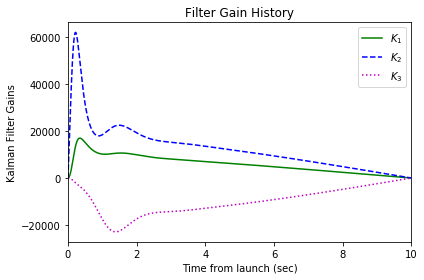

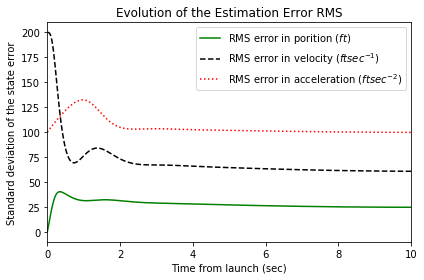

In [32]:
MSE.plot_for_problem_1(Log)

For the first graph, one-time simulation, Kalman gain converges to zero like a figure 9.6 at the textbook. Also, error RMS converges to steady values like figure 9.7.

### Problem 2: 
- Develop a simulation for the dynamics and the measurement.

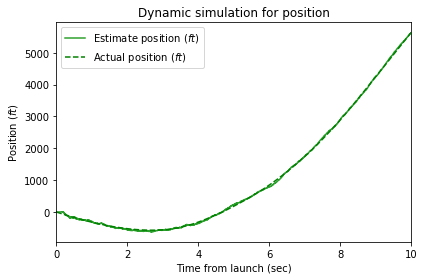

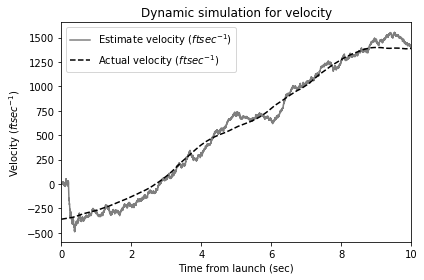

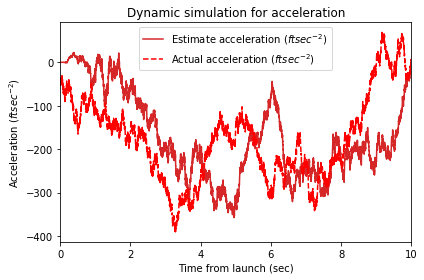

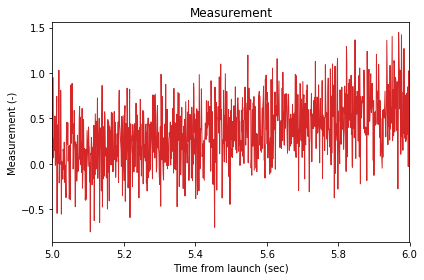

In [33]:
MSE.plot_for_problem_2(Log)

### Problem 3: 
- Show by a Monte Carlo simulation that the actual error variance computed in the simulation matches the a priori error variance used in the Kalman filter gains.

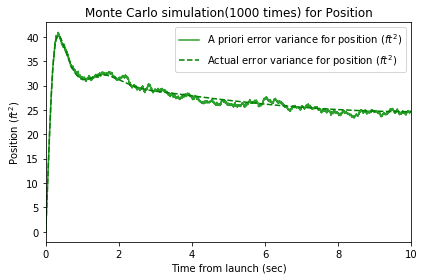

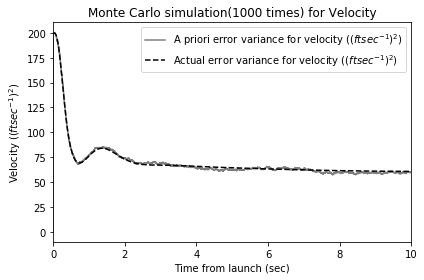

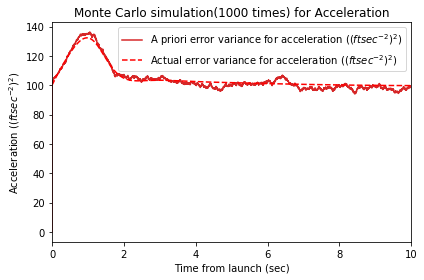

In [34]:
Pavg = MSE.AverageP(errstack, errtotal, T, itr)

MSE.plot_for_problem_3(Log, Pavg, itr)

A Monte Carlo simulation shows that the average of a priori error variances converged to the actual error variance.

### Problem 4: 
- Show that the residual process is uncorrelated in time, i.e. a white noise process.

In [17]:
# generate 4 random numbers(0 to 1000) for residual check
# cross validate check among each other
random_idx1 = np.random.randint(0, 1000)
random_idx2 = np.random.randint(0, 1000)
random_idx3 = np.random.randint(0, 1000)
random_idx4 = np.random.randint(0, 1000)

result1 = MSE.residual_check(residual, random_idx1, random_idx2)
result2 = MSE.residual_check(residual, random_idx1, random_idx3)
result3 = MSE.residual_check(residual, random_idx1, random_idx4)
result4 = MSE.residual_check(residual, random_idx2, random_idx3)
result5 = MSE.residual_check(residual, random_idx2, random_idx4)
result6 = MSE.residual_check(residual, random_idx3, random_idx4)
    
print('residual check for %r'%random_idx1,'time step and %r'%random_idx2,': %r'%result1)    
print('residual check for %r'%random_idx1,'time step and %r'%random_idx3,': %r'%result2)    
print('residual check for %r'%random_idx1,'time step and %r'%random_idx4,': %r'%result3)    
print('residual check for %r'%random_idx2,'time step and %r'%random_idx3,': %r'%result4)    
print('residual check for %r'%random_idx2,'time step and %r'%random_idx4,': %r'%result5)    
print('residual check for %r'%random_idx3,'time step and %r'%random_idx4,': %r'%result6)
    

residual check for 444 time step and 654 : 6.664990285724922e-06
residual check for 444 time step and 23 : 2.010898633895734e-06
residual check for 444 time step and 291 : 4.765705342135878e-06
residual check for 654 time step and 23 : 1.007709401080657e-05
residual check for 654 time step and 291 : 2.388208930624616e-05
residual check for 23 time step and 291 : 7.205480983725534e-06


Cross validate residual logs among arbitrary sampled 4 time steps.
All computation results almost zero, so residuals are uncorrelated in time.

### Problem 5: 
- The Gauss-Markov model is an approximation to the random telegraph signal model that is
more realistic.

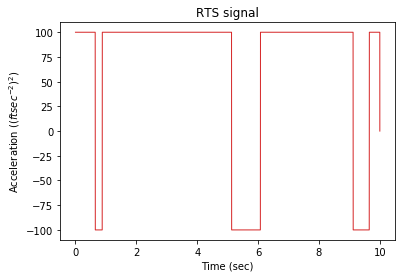

In [39]:
MSE.RTS_Example(T)

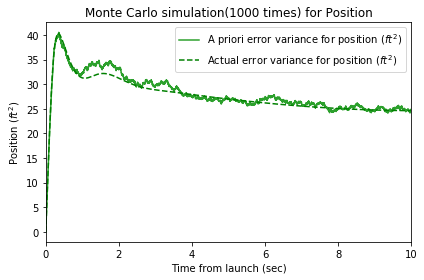

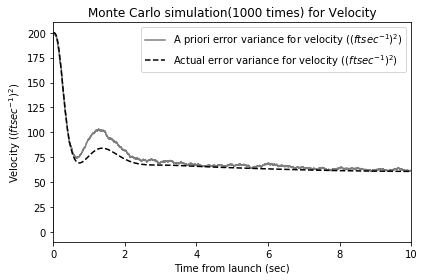

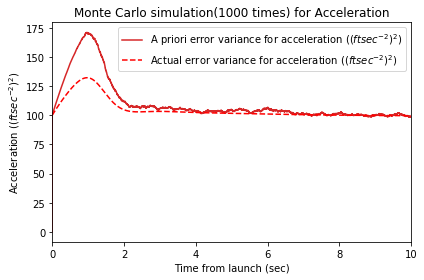

In [40]:
RTS_Pavg = MSE.AverageP(RTS_errstack, RTS_errtotal, T, itr)
MSE.plot_for_problem_5(Log, RTS_Pavg, itr)

By replacing a Gaussian noise to the RTS signal, the Monte Carlo simulation result shows that the variances of velocity and acceleration are fairly larger than the actual error in the early few seconds. Then, the RTS signal model quickly converges to actual error variance and worked well for replacing Gaussian noise.

Reference : Chapter 9, Stochastic Processes, Estimation, and Control 
    [Jason L. Speyer & Walter H. Chung]